# Analysing review composition with full annotations

**This notebook produces Figures 2 and 3 in the JCLS paper.**

We want to analyse how reviews are composed of sentences mentioning the various categories. That is, if we look at the reviews with a certain number of sentences, what fraction of reviews mention a category? and what fraction of sentences per review mention a category?

## Reading annotations and metadata

We start with reading the annotation data, as well as metadata per book and per review.

### Step 1.a: annotations

In [2]:
import time as time

import numpy as np
import pandas as pd

from impfic_core.map.map_genre import read_genre_file

anno_file = '../data/prediction-robbert-counts-reviews.tsv.gz'
review_meta_file = '../data/review-stats.tsv.gz'
book_genre_file = '../data/work_isbn_title_genre.tsv.gz'

anno_reviews = pd.read_csv(anno_file, sep='\t')

In [3]:
print(anno_reviews.shape)
anno_reviews.head(2)

(670748, 22)


,review_id,num_sentences,aut,cla,con,oth,rea,rec,sty,con_nar,...,con_the,rea_eva,rea_fee,rea_ide,rea_rea,rea_rec,rea_ref,sty_con,sty_str,sty_sty
0,impfic-review-1,13,0,1,11,0,4,1,0,11,...,0,3,0,0,0,0,0,0,0,0
1,impfic-review-10,14,0,0,9,1,4,1,1,7,...,1,4,0,0,0,1,1,0,1,0


### Step 1.b: book genre information

In [4]:
genre_df = read_genre_file(book_genre_file)
genre_df = genre_df[['work_id', 'nur_genre']].drop_duplicates()
genre_df.head(2)

,work_id,nur_genre
0,impfic-work-1,Non-fiction
3,impfic-work-2,Children_fiction


### Step 1.c: review metadata

We normalise the review length by taking the logarithm of the number of words (the distribution of number of words is roughly log-normal, so taking the logarithm results in a normal distribution).

Next, we bin the reviews by normalised length, using steps of 0.5 per bin.

In [5]:
review_df = pd.read_csv(review_meta_file, sep='\t', compression='gzip')

review_df['length_log'] = review_df.review_num_words.apply(lambda x: np.log(x+1))
review_df['length_log_bin'] = review_df.review_num_words.apply(lambda x: int(np.log(x+1) * 2)/2)


review_df.head(2)

,source,user_id,review_id,review_num_terms,review_num_words,num_sentences,review_date,rating,work_id,length_log,length_log_bin
0,NBD_Biblion,impfic-user-210320,impfic-review-1,206,185,13,NaN,NaN,impfic-work-3723,5.225747,5.0
1,NBD_Biblion,impfic-user-210320,impfic-review-2,212,185,7,NaN,NaN,impfic-work-36913,5.225747,5.0


### Step 2: combining book genre and review metadata

Next, we combine the review metadata and the book genre information so we have book genre information per review.

In [6]:
review_genre = pd.merge(review_df, genre_df, on='work_id')
review_genre['nur_genre'] = review_genre.nur_genre.apply(lambda x: 'unknown' if pd.isna(x) else x)

In [7]:
review_genre.head(2)

,source,user_id,review_id,review_num_terms,review_num_words,num_sentences,review_date,rating,work_id,length_log,length_log_bin,nur_genre
0,NBD_Biblion,impfic-user-210320,impfic-review-1,206,185,13,NaN,NaN,impfic-work-3723,5.225747,5.0,Young_adult
1,NBD_Biblion,impfic-user-210320,impfic-review-2,212,185,7,NaN,NaN,impfic-work-36913,5.225747,5.0,Literary_fiction


### Step 4: combining annotations and metadata

Finally, we merge the review information with the annotations:

In [8]:
anno_review = pd.merge(review_genre.drop('num_sentences', axis=1), anno_reviews, 
                       on='review_id', how='right')



### Step 5: Binning reviews by logarithm of number of sentences

We also bin reviews by the logarithm of the number of sentences, so we can analyse the relationship between review composition and review length (because longer reviews will have more sentences and more category mentions).


In [9]:
bin_frac = 10

anno_review['log_sents'] = anno_review.num_sentences.apply(lambda x: int((np.log(x)/np.log(10)) * bin_frac) / bin_frac)

anno_review.num_sentences.apply(lambda x:  int(np.log(x+1) * bin_frac) / bin_frac).value_counts().sort_index()
anno_review.log_sents.value_counts().sort_index()

log_sents
0.0     60464
0.3     68282
0.4     74859
0.6    115406
0.7     39772
0.8     31854
0.9     52271
1.0     57708
1.1     37301
1.2     32600
1.3     33872
1.4     24203
1.5     20694
1.6     12734
1.7      4878
1.8      2149
1.9       982
2.0       409
2.1       148
2.2        97
2.3        33
2.4        23
2.5         6
2.6         3
2.7         3
Name: count, dtype: int64

We also add a linear representation of the same bins.

In [10]:
def make_log_bin(num_sents, bin_frac: int):
    log_sents = np.log(num_sents) / np.log(10)
    log_bin = int(log_sents * bin_frac) / bin_frac
    lin_bin = int(np.power(10, log_bin))
    lin_bin = np.power(10, log_bin)
    
    return lin_bin

bin_frac = 10
anno_review['lin_bin_sents'] = anno_review.num_sentences.apply(lambda x: make_log_bin(x, bin_frac))


In [11]:
anno_review.lin_bin_sents.value_counts().sort_index()

lin_bin_sents
1.000000       60464
1.995262       68282
2.511886       74859
3.981072      115406
5.011872       39772
6.309573       31854
7.943282       52271
10.000000      57708
12.589254      37301
15.848932      32600
19.952623      33872
25.118864      24203
31.622777      20694
39.810717      12734
50.118723       4878
63.095734       2149
79.432823        982
100.000000       409
125.892541       148
158.489319        97
199.526231        33
251.188643        23
316.227766         6
398.107171         3
501.187234         3
Name: count, dtype: int64

In [12]:
cat_cols = [
    'aut', 'cla', 'con', 'oth', 'rea', 'rec', 'sty', 'con_nar', 'con_oth',
    'con_quo', 'con_the', 'rea_eva', 'rea_fee', 'rea_ide', 'rea_rea',
    'rea_rec', 'rea_ref', 'sty_con', 'sty_str', 'sty_sty'
]

In [13]:
anno_review.nur_genre.value_counts()

nur_genre
Literary_fiction      201059
Non-fiction           108884
unknown                94891
Literary_thriller      77051
Suspense               68560
Other fiction          37410
Young_adult            30259
Children_fiction       27458
Fantasy_fiction        13761
Romance                 6423
Historical_fiction      3467
Regional_fiction        1528
Name: count, dtype: int64

# Review length and the presence and sentence share of categories

Now that the data is prepared, we can start the analysis. We are interested in the share of sentences that contain a given category and how this relates to the total number of sentences in a review.

We analyse this relationship for the main categories: _Author_, _Classification_, _Content_, _Other works_, _Reader response_, _Recommendation_ and _Style_. We generate two plots:

1. the fraction of reviews in a length bin that with at least one sentence that contains a main category. In other words, the fraction of reviews in a length bin in which a main category is present.
2. The distribution, per length bin, of the fraction of sentences in a review that contain a main category. This shows us how much of a review is composed of statements about each of the main category and how this relates to review length.



In [14]:
main_cats = ['aut', 'cla', 'con', 'oth', 'rea', 'rec', 'sty']
sub_cats = [col for col in cat_cols if col not in main_cats]

# Calculate the fraction of the total number of sentences that contain a given category.
# This dataframe contains only the fractions per category
anno_frac = anno_review[cat_cols].T.div(anno_review.num_sentences).T
# select the metadata columns
anno_meta = anno_review[[col for col in anno_review.columns if col not in cat_cols]]
# Merge the metadata and the fractions
anno_frac = pd.concat([anno_meta, anno_frac], axis=1)


In [15]:
main_cat_map = {
    'aut': 'Author',
    'cla': 'Classification',
    'con': 'Content',
    'oth': 'Other works',
    'rea': 'Reader response',
    'rec': 'Recommendation',
    'sty': 'Style'
}

Load Seaborn for plotting and set a grid as background.

In [16]:
import seaborn as sns

sns.set_theme(style='whitegrid')

### Review length and the presence of categories

What fraction of reviews has at least one sentence with a main category? And how is this related to the total number of sentences in a review?

In [17]:
anno_review.lin_bin_sents.value_counts().sort_index()

lin_bin_sents
1.000000       60464
1.995262       68282
2.511886       74859
3.981072      115406
5.011872       39772
6.309573       31854
7.943282       52271
10.000000      57708
12.589254      37301
15.848932      32600
19.952623      33872
25.118864      24203
31.622777      20694
39.810717      12734
50.118723       4878
63.095734       2149
79.432823        982
100.000000       409
125.892541       148
158.489319        97
199.526231        33
251.188643        23
316.227766         6
398.107171         3
501.187234         3
Name: count, dtype: int64

The peak of the distribution is around 4 sentences. That is, the bin of reviews with around 4 sentences is the biggest. Up to 126 sentences, the bins contain at least one hundred reviews, providing enough data points for a reliable statistical signal. Beyond that we need to be more careful with interpreting results and drawing conclusions.


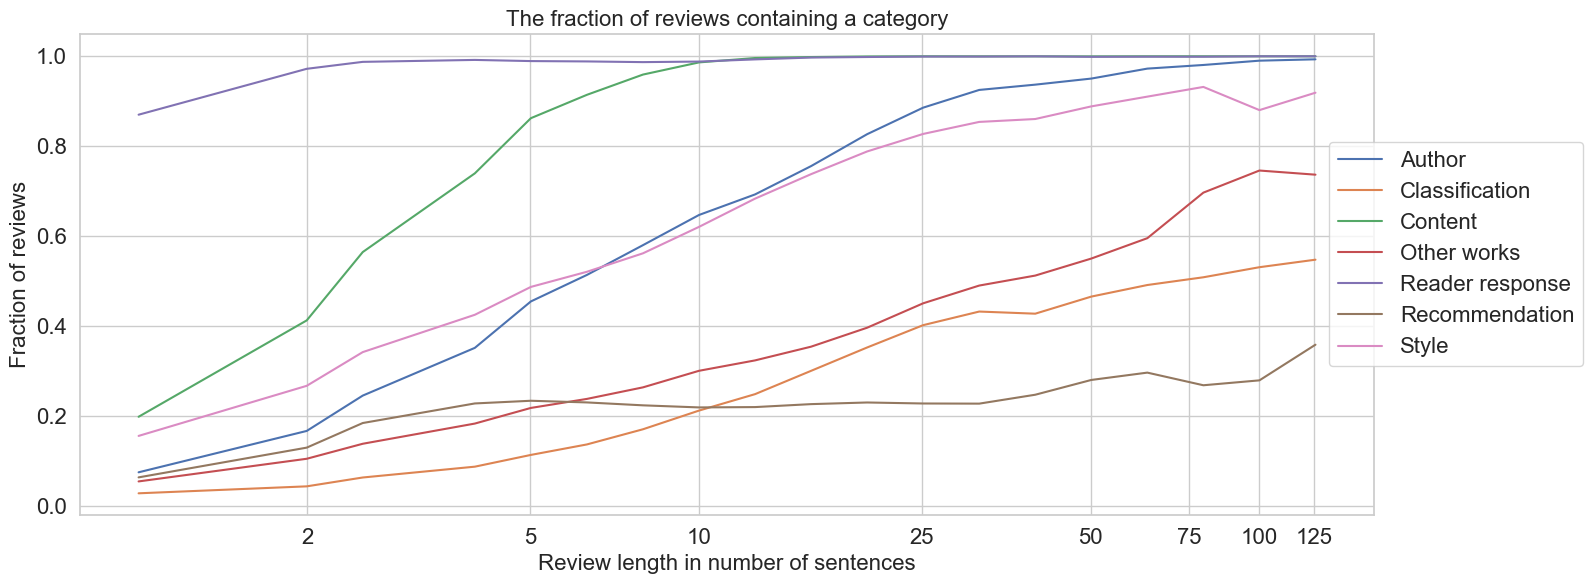

In [18]:
import matplotlib.ticker as mticker

temp = anno_review.melt(id_vars=['log_sents', 'lin_bin_sents'], value_vars=main_cats, 
                        value_name='freq', var_name='category')
# 'presence' is a binary indication whether a category is present in any of the sentences of a review or not.
temp['presence'] = temp.freq.apply(lambda x: 1 if x > 0 else 0)

bin_col = 'lin_bin_sents'

temp = temp.groupby([bin_col, 'category']).presence.value_counts().unstack().fillna(0.0)
temp['freq_sum'] = temp.sum(axis=1)
temp = temp[1].div(temp.freq_sum).unstack().reset_index().melt(id_vars=bin_col, var_name='category', value_name='fraction')
temp['category'] = temp.category.apply(lambda cat: main_cat_map[cat])

# We limit the plot to the bins with at least 100 reviews
temp = temp[temp.lin_bin_sents.between(1.0, 126.0)]

ax = sns.lineplot(temp, x=bin_col, y='fraction', hue='category')
ax.set_xlabel('Review length in number of sentences', fontsize=16)
ax.set_ylabel('Fraction of reviews', fontsize=16)
ax.set_title('The fraction of reviews containing a category', fontsize=16)
ax.set_xscale('log')
ax.set_xticks([2, 5, 10, 25, 50, 75, 100, 125])
ax.get_xaxis().set_major_formatter(mticker.ScalarFormatter())

#ax.set_ylim(0.0, 1.0)
ax.legend(prop={'size': 16},
          #loc='best', 
          bbox_to_anchor=(0.87, 0.5, 0.3, 0.3)
         )

ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.figure.set_size_inches(16, 6)
ax.figure.tight_layout()
ax.figure.savefig('../images/composition/category-review_fraction-all_reviews_annotations.png', dpi=150)

This corresponds to Figure 2 in the paper. 

### Review length and the sentence share of categories

The second plot shows what fraction of a review's sentences mention a main category. How is this related to the total number of sentences in a review?

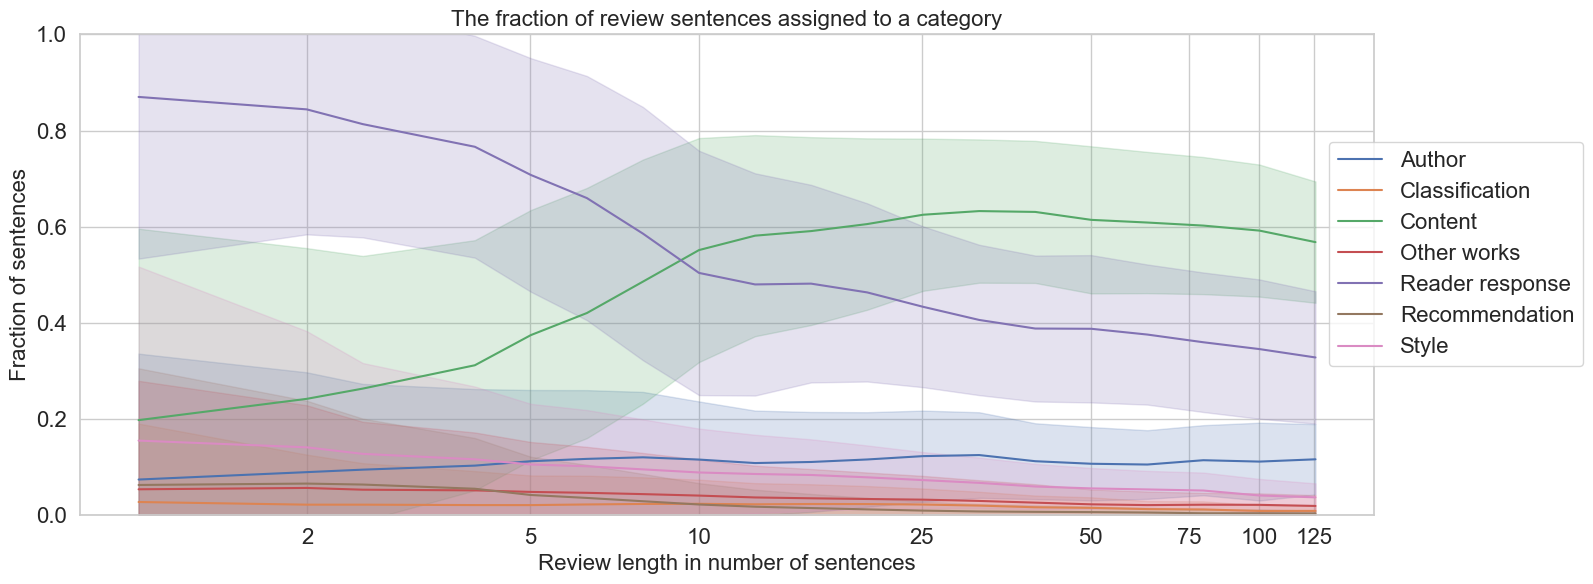

In [19]:
anno_frac_wide = anno_frac.melt(id_vars=['num_sentences', 'log_sents', 'lin_bin_sents', 'nur_genre'], value_vars=main_cats, value_name='fraction', var_name='category')
anno_frac_wide['category'] = anno_frac_wide.category.apply(lambda cat: main_cat_map[cat])

temp = anno_frac_wide[anno_frac_wide.lin_bin_sents.between(1.0, 126.0)]

ax = sns.lineplot(temp, x='lin_bin_sents', y='fraction', hue='category', errorbar='sd')
ax.set_xscale('log')
ax.set_xticks([2, 5, 10, 25, 50, 75, 100, 125])
ax.get_xaxis().set_major_formatter(mticker.ScalarFormatter())

ax.set_xlabel('Review length in number of sentences', fontsize=16)
ax.set_ylabel('Fraction of sentences', fontsize=16)
ax.set_title('The fraction of review sentences assigned to a category', fontsize=16)
ax.set_ylim(-0.2, 1.4)
ax.set_ylim(0.0, 1.0)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.legend(prop={'size': 16},
          #loc='best', 
          bbox_to_anchor=(0.87, 0.5, 0.3, 0.3)
         )
ax.figure.set_size_inches(16, 6)
ax.figure.tight_layout()
ax.figure.savefig('../images/composition/category-review_sent_fraction-all_reviews_annotations.png', dpi=150)

This corresponds to Figure 3 in the paper. 